In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score

In [2]:
df = pd.read_csv('/content/Training_Set_Preprocessed_Final.csv')

In [3]:
df_train, df_temp = train_test_split(df, test_size=0.3, random_state=42)
df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=42)

In [4]:
print(f"Original dataframe size: {len(df)}")
print(f"Training set size: {len(df_train)}")
print(f"Validation set size: {len(df_val)}")
print(f"Testing set size: {len(df_test)}")

Original dataframe size: 50000
Training set size: 35000
Validation set size: 7500
Testing set size: 7500


In [5]:
class HybridNaiveBayes(BaseEstimator, ClassifierMixin):
    def __init__(self, categorical_features, numerical_features, alpha=1.0, var_smoothing=1e-9):
        self.categorical_features = categorical_features
        self.numerical_features = numerical_features
        self.alpha = alpha
        self.var_smoothing = var_smoothing
        self.multi_nb = MultinomialNB(alpha=self.alpha)
        self.gauss_nb = GaussianNB(var_smoothing=self.var_smoothing)
        self.classes_ = None

    def fit(self, X, y):
        X_cat = X[self.categorical_features].values
        X_num = X[self.numerical_features].values

        self.multi_nb = MultinomialNB(alpha=self.alpha)
        self.gauss_nb = GaussianNB(var_smoothing=self.var_smoothing)

        self.multi_nb.fit(X_cat, y)
        self.gauss_nb.fit(X_num, y)

        self.classes_ = self.multi_nb.classes_
        return self

    def predict_log_proba(self, X):
        X_cat = X[self.categorical_features].values
        X_num = X[self.numerical_features].values

        log_prob_cat = self.multi_nb.predict_log_proba(X_cat)
        log_prob_num = self.gauss_nb.predict_log_proba(X_num)

        return log_prob_cat + log_prob_num

    def predict(self, X):
        combined_log_proba = self.predict_log_proba(X)
        return self.classes_[np.argmax(combined_log_proba, axis=1)]

In [6]:
# === Define your dataset
numerical_features = ['Age', 'Billing Amount']
categorical_features = [col for col in df_train.columns if col not in numerical_features + ['Test Results']]
X = df_train[categorical_features + numerical_features]
y = df_train['Test Results']

# === Define parameter grid
param_grid = {
    'alpha': [0.01, 0.1, 1.0],
    'var_smoothing': [1e-11, 1e-9, 1e-7]
}

# === Wrap in GridSearchCV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
hybrid_model = HybridNaiveBayes(categorical_features, numerical_features)

grid = GridSearchCV(hybrid_model, param_grid, cv=skf, scoring='accuracy', n_jobs=-1, verbose=2)
grid.fit(X, y)

# === Best model
print("Best parameters:", grid.best_params_)
print("Best CV accuracy:", grid.best_score_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters: {'alpha': 1.0, 'var_smoothing': 1e-11}
Best CV accuracy: 0.7565999999999999


In [7]:
best_model = grid.best_estimator_
y_pred = best_model.predict(X)

In [8]:
X_val = df_val[categorical_features + numerical_features]
y_val = df_val['Test Results']

X_test = df_test[categorical_features + numerical_features]
y_test = df_test['Test Results']

# === Predict on validation set
y_val_pred = best_model.predict(X_val)
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred))

# === Predict on test set
y_test_pred = best_model.predict(X_test)
print("Test Classification Report:")
print(classification_report(y_test, y_test_pred))

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.73      0.74      2464
           1       0.72      0.74      0.73      2509
           2       0.79      0.78      0.78      2527

    accuracy                           0.75      7500
   macro avg       0.75      0.75      0.75      7500
weighted avg       0.75      0.75      0.75      7500

Test Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.75      0.76      2547
           1       0.72      0.74      0.73      2440
           2       0.80      0.80      0.80      2513

    accuracy                           0.76      7500
   macro avg       0.76      0.76      0.76      7500
weighted avg       0.76      0.76      0.76      7500



In [9]:
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))

Validation Accuracy: 0.7516
Test Accuracy: 0.7606666666666667


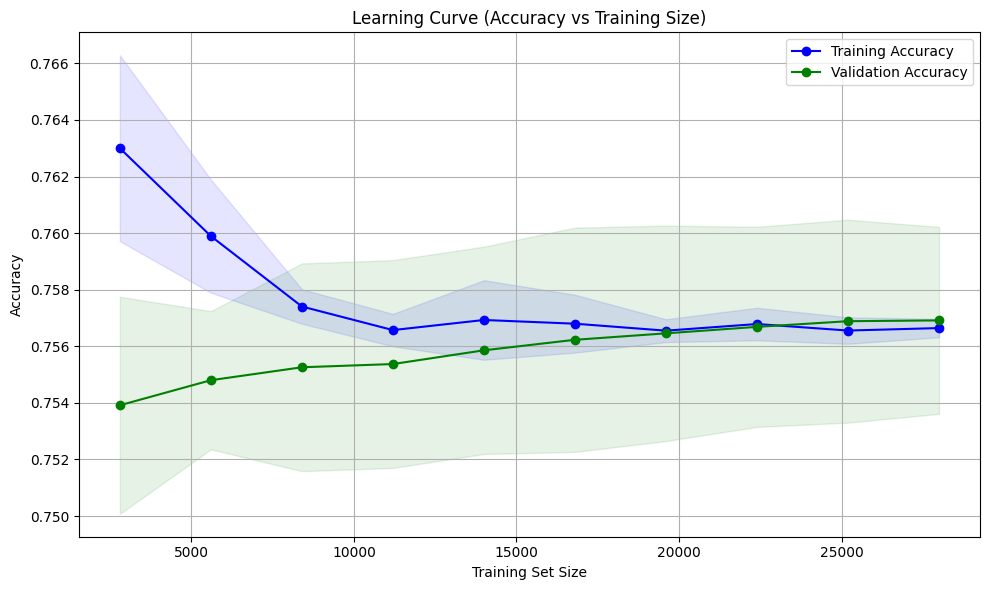

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# Generate learning curve data
train_sizes, train_scores, val_scores = learning_curve(
    best_model, X, y, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)


# Mean and std
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Training Accuracy')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color='blue')

plt.plot(train_sizes, val_scores_mean, 'o-', color='green', label='Validation Accuracy')
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.1, color='green')

plt.title('Learning Curve (Accuracy vs Training Size)')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()


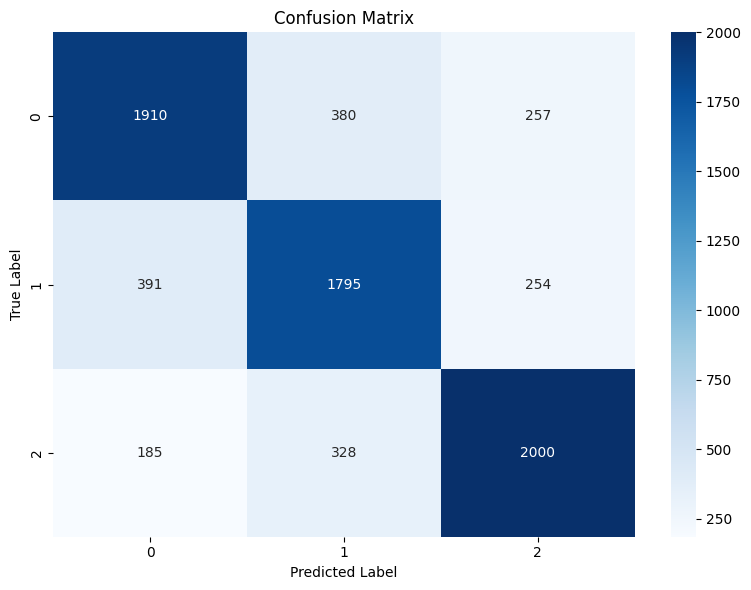

In [16]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on the test set
y_test = df_test['Test Results']
X_test = df_test.drop('Test Results', axis=1)
y_pred = best_model.predict(X_test)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = best_model.classes_  # Get class labels from the model

# Plot using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()
